# Correlation between hammign distance delt-delta-auc-pr

The hypothesis I will be testing in this notebook is that assay pairs with lower hamming distances will have delta-auc-pr scores that are closer to each other.

I will test all pairs of assays for nci60 and meic.

In [214]:
import os
import numpy as np
import pandas as pd
import duckdb
from itertools import product
from scipy.spatial.distance import hamming
from tqdm import tqdm

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
con = duckdb.connect()
datasets = ["meic", "nci60"]

assay_scores = pd.DataFrame(columns=["assay_id", "delta_auc_pr"])

for dataset in datasets:
    filepath = f"/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-27/12-00-04/params.dataset={dataset}/data/processed/score/*"
    query = f"""
    SELECT delta_auc_pr, filename AS assay_id
    FROM read_parquet('{filepath}', filename=True)
    """
    tmp = con.execute(query).df()
    tmp["assay_id"] = tmp["assay_id"].apply(lambda x: os.path.basename(x).split(".")[0])
    tmp["dataset"] = dataset
    assay_scores = pd.concat([assay_scores, tmp])

In [216]:
assay_scores.head()

,assay_id,delta_auc_pr,dataset
0,ddd5a240d7bec48,0.207246,meic
1,9d8d134d88b4b2f,0.248260,meic
2,b12eb94097d71ed,0.263935,meic
0,b18b1b159d11854,0.392192,nci60
1,59e9c35a3e26f97,0.361611,nci60


In [217]:
# Get delta-delta-auc-pr scores
meic = assay_scores[assay_scores["dataset"] == "meic"]
nci60 = assay_scores[assay_scores["dataset"] == "nci60"]

delta_matrix = np.zeros((len(nci60_assays), len(meic_assays)))
for i, row1 in nci60.iterrows():
    for j, row2 in meic.iterrows():
        delta_matrix[i,j] = row1["delta_auc_pr"] - row2["delta_auc_pr"]
        
delta_matrix = np.abs(delta_matrix)

# Create a DataFrame from the matrix and assign labels
delta_df = pd.DataFrame(delta_matrix, index=nci60_assays, columns=meic_assays)

In [218]:
delta_df.head()

,ddd5a240d7bec48,9d8d134d88b4b2f,b12eb94097d71ed
cd30091d598d9fe,0.184946,0.143932,0.128257
7c3f25271fd30fa,0.154365,0.113351,0.097676
8491cca19882d2b,0.075773,0.034758,0.019084
d7c9562a98f62c7,0.046402,0.005387,0.010287
5bec0557c649d93,0.144959,0.103945,0.088270


In [221]:
# Get assay fingerprints
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-27/12-00-04"
run_dirs = [f"{INPUT_DIR}/params.dataset={dataset}" for dataset in datasets]
assay_dirs = [f"{run_dir}/data/processed/assay" for run_dir in run_dirs]
feature_dirs = [f"{run_dir}/data/processed/feature" for run_dir in run_dirs]

dfs = [] 

bit_cols = [f"bit_{i}" for i in range(1024)]
bit_col_string = ", ".join(bit_cols)

for run in zip(assay_dirs, feature_dirs):
    # Read in all assay data from a given folder
    con = duckdb.connect()
    query = f"""
    SELECT a.canonical_smiles AS canonical_smiles, source_id, assay_id, {bit_col_string}
    FROM read_parquet('{run[0]}/*.parquet') AS a
    JOIN read_parquet('{run[1]}/*.parquet') AS b
    ON a.canonical_smiles = b.canonical_smiles
    """
    df = con.execute(query).df()
    dfs.append(df)

# Join constituent dataframes together
feature_df = pd.concat(dfs)

In [222]:
feature_df.head()

,canonical_smiles,source_id,assay_id,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,...,bit_1014,bit_1015,bit_1016,bit_1017,bit_1018,bit_1019,bit_1020,bit_1021,bit_1022,bit_1023
0,CC(=O)Nc1ccc(O)cc1,meic,ddd5a240d7bec48,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CC(=O)Oc1ccccc1C(=O)O,meic,ddd5a240d7bec48,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,O=S(=O)([O-])[O-].[Fe+2],meic,ddd5a240d7bec48,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,meic,ddd5a240d7bec48,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CN(C)CCC=C1c2ccccc2CCc2ccccc21.Cl,meic,ddd5a240d7bec48,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
# Get assays for nci60 and meic
nci60_assays = feature_df[feature_df["source_id"] == "nci60"]["assay_id"].unique()
meic_assays = feature_df[feature_df["source_id"] == "meic"]["assay_id"].unique()

# Prepare dataframe to store outcomes
outcomes = pd.DataFrame(columns=['nci60', 'meic', 'median_tanimoto_distance'])

# Loop through each pair of assays
for i, nci60_assay in tqdm(enumerate(nci60_assays), total=len(nci60_assays)):
    nci60 = feature_df[feature_df["assay_id"] == nci60_assay]["canonical_smiles"].sample(50, replace=True)
    for meic_assay in meic_assays:
        meic = feature_df[feature_df["assay_id"] == meic_assay]["canonical_smiles"]

        tanimoto_distances = []
        
        # Calculate hamming distances for each rows pair
        for smiles1 in nci60:
            for smiles2 in meic:
                # Calculate hamming distance between row of each dataframe
                # Create two molecule objects using Simplified Molecular Input Line Entry System (SMILES) notation
                mol1 = Chem.MolFromSmiles(smiles1)
                mol2 = Chem.MolFromSmiles(smiles2)

                # Generate Morgan fingerprints for both molecules
                fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=1024)
                fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=1024)

                # Calculate Tanimoto similarity
                similarity = DataStructs.TanimotoSimilarity(fp1, fp2)

                tanimoto_distances.append(similarity)
    
        # Get median distance for pair of assays
        median_distance = np.median(tanimoto_distances)

        # Add row to assay pair dataframe
        outcomes = pd.concat([outcomes, pd.DataFrame([{'nci60': nci60_assay, 'meic': meic_assay, 'median_tanimoto_distance': median_distance}])], ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [01:56<00:00,  1.74s/it]


In [230]:
outcomes.head()

,nci60,meic,median_tanimoto_distance
0,cd30091d598d9fe,ddd5a240d7bec48,0.068966
1,cd30091d598d9fe,9d8d134d88b4b2f,0.068966
2,cd30091d598d9fe,b12eb94097d71ed,0.068966
3,d01419737a74a9a,ddd5a240d7bec48,0.065217
4,d01419737a74a9a,9d8d134d88b4b2f,0.065217


In [232]:
outcome_pivot = outcomes.pivot_table(values='median_tanimoto_distance', index='nci60', columns='meic')

In [233]:
outcome_pivot.head()

meic,9d8d134d88b4b2f,b12eb94097d71ed,ddd5a240d7bec48
nci60,,,
01db96bc277c315,0.065682,0.065682,0.065682
0518bdeddbf085b,0.066667,0.066667,0.066667
09be8f23d2cf53f,0.069444,0.069444,0.069444
0d1cbb0140c60b6,0.068966,0.068966,0.068966
0ed7fb5733af4c0,0.067797,0.067797,0.067797


In [234]:
# Sort the rows and columns of each dataframe
outcome_pivot.sort_index(axis=0, inplace=True)  # sorts rows
outcome_pivot.sort_index(axis=1, inplace=True)  # sorts columns

# Sort the rows and columns of df2
delta_df.sort_index(axis=0, inplace=True)  # sorts rows
delta_df.sort_index(axis=1, inplace=True)  # sorts columns

In [235]:
hamming_vector = outcome_pivot.values.ravel()
delta_vector = delta_df.values.ravel()

In [236]:
np.corrcoef(hamming_vector, delta_vector)

array([[ 1.        , -0.12495638],
       [-0.12495638,  1.        ]])

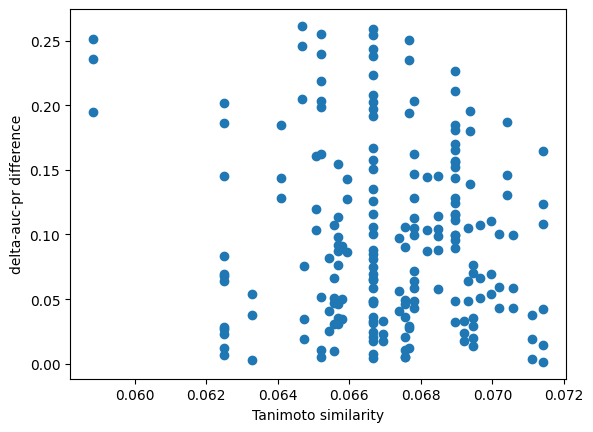

In [239]:
plt.scatter(hamming_vector, delta_vector)
plt.xlabel("Tanimoto similarity")
plt.ylabel("delta-auc-pr difference")
plt.show()